Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


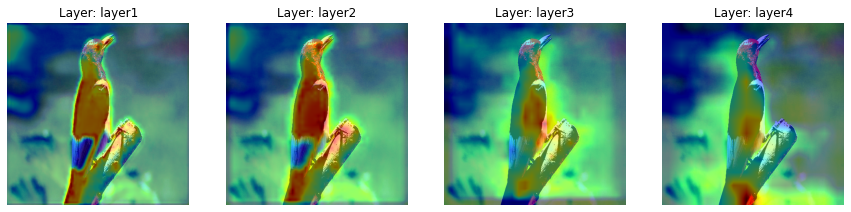

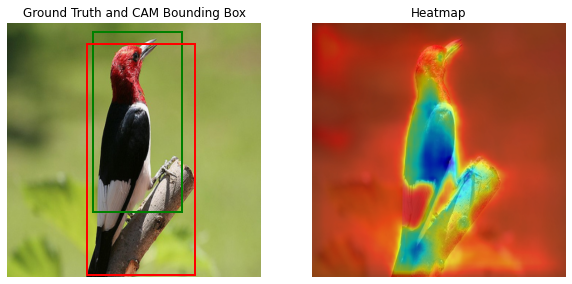

In [13]:
import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
import cv2

# Dataset class
class CUB200Dataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = pd.read_csv(os.path.join(root_dir, 'images.txt'), sep=' ', names=['id', 'filepath'])
        self.labels = pd.read_csv(os.path.join(root_dir, 'image_class_labels.txt'), sep=' ', names=['id', 'label'])
        self.bboxes = pd.read_csv(os.path.join(root_dir, 'bounding_boxes.txt'), sep=' ', names=['id', 'x', 'y', 'width', 'height'])
    
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, 'images', self.images.iloc[idx]['filepath'])
        image = Image.open(img_path).convert('RGB')
        bbox = self.bboxes.iloc[idx][['x', 'y', 'width', 'height']].values
        bbox = torch.tensor(bbox, dtype=torch.float32)
        label = self.labels.iloc[idx]['label']
        if self.transform:
            image = self.transform(image)
        return image, label, bbox

# Image transformation
def cub_transform(image_size=448):
    train_transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    ])
    return train_transform

train_transform = cub_transform()
train_dataset = CUB200Dataset(root_dir='CUB_200_2011/CUB_200_2011', transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

# Load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained=True)
model.load_state_dict(torch.load('cub_pytorch_resnet50.pth', map_location=device))
model = model.to(device)
model.eval()

# Adjust threshold for CAM extraction
def extract_high_intensity_region(heatmap, threshold=0.7):  # Increased threshold for more focus
    _, thresholded = cv2.threshold(heatmap, threshold * heatmap.max(), 255, cv2.THRESH_BINARY)
    thresholded = np.uint8(thresholded)
    contours, _ = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        return cv2.boundingRect(largest_contour)
    return 0, 0, 0, 0  # If no contours are found

# GradCAM class
import torch.nn.functional as F
class GradCAM:
    def __init__(self, model, layers):
        self.model = model
        self.layers = layers
        self.gradients = {}
        self.feature_maps = {}
        self.model.eval()
        self.register_hooks()

    def save_gradient(self, layer_name):
        def hook(module, grad_input, grad_output):
            self.gradients[layer_name] = grad_output[0]
        return hook

    def forward_hook(self, layer_name):
        def hook(module, input, output):
            self.feature_maps[layer_name] = output
        return hook

    def register_hooks(self):
        for layer_name in self.layers:
            layer = dict([*self.model.named_modules()])[layer_name]
            layer.register_forward_hook(self.forward_hook(layer_name))
            layer.register_full_backward_hook(self.save_gradient(layer_name))

    def generate_cam(self, input_image, target_class):
        model_output = self.model(input_image)
        if target_class is None:
            target_class = model_output.argmax(dim=1)
        
        class_loss = model_output[:, target_class]
        self.model.zero_grad()
        class_loss.backward()

        cams = []
        for layer_name in self.layers:
            gradients = self.gradients[layer_name]
            feature_maps = self.feature_maps[layer_name]
            pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
            for i in range(pooled_gradients.size(0)):
                feature_maps[0][i, :, :] *= pooled_gradients[i]
            cam = torch.sum(feature_maps[0], dim=0)
            cam = torch.relu(cam)
            cam = cam - cam.min()
            cam = cam / cam.max()
            cam = cv2.resize(cam.detach().cpu().numpy(), (input_image.shape[2], input_image.shape[3]))  # Resize to input image size
            cams.append(cam)
        
        # Combine CAMs from multiple layers
        combined_cam = np.mean(cams, axis=0)
        return combined_cam

# Apply colormap on image
def apply_colormap_on_image(org_img, cam, alpha=0.8):
    # Ensure original image is in the correct format
    if org_img.dtype != np.uint8:
        org_img = np.uint8(255 * org_img)

    # Enhance the CAM contrast
    cam = enhance_cam_contrast(cam, 'power', 2)  # This calls the previously defined function
    cam_resized = cv2.resize(cam, (org_img.shape[1], org_img.shape[0]))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)

    # Check if original image is single channel, convert it to 3 channels
    if len(org_img.shape) == 2 or org_img.shape[2] == 1:
        org_img = cv2.cvtColor(org_img, cv2.COLOR_GRAY2RGB)

    # Blend the heatmap with the original image
    final_image = cv2.addWeighted(org_img, 1 - alpha, heatmap, alpha, 0)
    return final_image

def enhance_cam_contrast(cam, method='power', factor=2):
    if method == 'log':
        cam = np.log1p(cam)
    elif method == 'power':
        cam = np.power(cam, factor)
    cam = cam - cam.min()  # Normalize
    cam = cam / cam.max()
    return cam

def apply_clahe(heatmap):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    heatmap_gray = cv2.cvtColor(heatmap, cv2.COLOR_BGR2GRAY)
    return clahe.apply(heatmap_gray)

# Visualize GradCAM
def visualize_gradcam(image, gt_bbox, cam_bbox, heatmap):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.gca().add_patch(plt.Rectangle((gt_bbox[0], gt_bbox[1]), gt_bbox[2], gt_bbox[3], fill=False, edgecolor='green', linewidth=2))
    plt.gca().add_patch(plt.Rectangle((cam_bbox[0], cam_bbox[1]), cam_bbox[2], cam_bbox[3], fill=False, edgecolor='red', linewidth=2))
    plt.title('Ground Truth and CAM Bounding Box')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(image)
    plt.imshow(heatmap, cmap='jet', alpha=0.8)  # Increased alpha for overlay
    plt.title('Heatmap')
    plt.axis('off')
    plt.show()

# Visualize CAM for different layers
def visualize_layer_gradcam(model, layers, image, label):
    fig, axs = plt.subplots(1, len(layers), figsize=(15, 5))
    for i, layer in enumerate(layers):
        grad_cam = GradCAM(model, [layer])
        cam = grad_cam.generate_cam(image.unsqueeze(0), label)
        cam_resized = cv2.resize(cam, (image.shape[2], image.shape[1]))
        heatmap = plt.cm.jet(cam_resized)[:, :, :3]
        axs[i].imshow(image.permute(1, 2, 0).numpy())
        axs[i].imshow(heatmap, alpha=0.5)
        axs[i].set_title(f'Layer: {layer}')
        axs[i].axis('off')
    plt.show()

# Main loop
layer_names = ['layer1', 'layer2', 'layer3', 'layer4']
for images, labels, bboxes in train_loader:
    images, labels, bboxes = images.to(device), labels.to(device), bboxes.to(device)
    outputs = model(images)
    target_class = labels[0].item()  # For demonstration

    # Visualize CAM for different layers
    visualize_layer_gradcam(model, layer_names, images[0], target_class)
    
    # layer = ['layer2', 'layer3', 'layer4']

    # Now using adjusted threshold and combined CAMs
    grad_cam = GradCAM(model, layer_names)  # Combine multiple layers
    cam = grad_cam.generate_cam(images, target_class)
    image_np = images.cpu().squeeze(0).permute(1, 2, 0).numpy()
    image_np = (image_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])).clip(0, 1)
    heatmap = apply_colormap_on_image(image_np, cam)
    cam_bbox = extract_high_intensity_region(cam, threshold=0.5)  # Adjusted threshold

    visualize_gradcam(image_np, bboxes[0].cpu().numpy(), cam_bbox, heatmap)
    break
